Написать свой код к разделам 1 - 5 согласно заданиям для всех фрагментов, помеченных как: <ВАШ КОД:>

Поиск по дереву Монте-Карло (MCTS) — это эвристический алгоритм поиска,
который показывает отличные результаты в таких сложных областях, как го и
шахматы. Алгоритм строит дерево поиска, итеративно обходит его и оценивает его
узлы с помощью моделирования методом Монте-Карло.


## 1 Предварительные действия

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
# Этот код создает виртуальный дисплей для рисования игровых изображений
# Это не будет иметь никакого эффекта, если на вашей машине есть монитор
import os

# Устанавливаем DISPLAY на значение ':1' (виртуальный дисплей)
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
 os.environ['DISPLAY'] = ':1'

Сначала нужно создать оболочку для сред Gym, позволяющую сохранять и загружать игровые состояния для облегчения возврата.

In [29]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import os
import gym
from gym.core import Wrapper
from pickle import dumps, loads
from collections import namedtuple

In [39]:
# Контейнер для хранения результатов выполнения действия
ActionResult = namedtuple(
    "action_result", ("snapshot", "observation", "reward", "is_done", "info"))

class WithSnapshots(Wrapper):
    """
    Создает оболочку, поддерживающую сохранение и загрузку состояний среды
    Это нужно для алгоритмов планирования, таких как MCTS

    Можно использовать self.render(), это создаст окно, которое нельзя замариновать
    Таким образом, нужно будет вызвать self.close(), прежде чем травление снова заработает
    """
    # Метод для сохранения текущего состояния среды (env) в виде снимка перед выполнением действия
    def get_snapshot(self, render=False):
        """
        Загружает сохраненный снимок в текущую среду
        :returns: состояние среды, которое можно загрузить с помощью load_snapshot
        Снимки гарантируют одинаковое поведение env при каждой загрузке
        Предупреждение! Снимки могут быть произвольными вещами (строки, целые числа, json, кортежи)

        """
        if render:
            self.render()  # Закрываем всплывающие окна, если есть
            self.close()

        if hasattr(self.unwrapped, 'viewer') and self.unwrapped.viewer is not None:
          # Закрываем viewer, чтобы избежать проблем с сохранением
            self.unwrapped.viewer.close()
            self.unwrapped.viewer = None
        # Создаем снимок состояния без графического компонента
        state = self.env.unwrapped.state  # или другие компоненты состояния, которые вы хотите сохранить
        # Сохраняем состояние среды с помощью pickle
        return dumps(state)

    # Метод для восстановления состояния среды из сохраненного ранее снимка (в предыдущее состояние)
    def load_snapshot(self, snapshot, render=False):
        """
        Загружает сохраненный снимок в текущую среду
        Не следует менять снапшот на месте
        """
        # Проверяем, что запись не активна, чтобы избежать ошибок
        assert not hasattr(self, "_monitor") or hasattr(
            self.env, "_monitor"), "не могу вернуться во время записи"
        if render:
            self.render()  # Закрываем всплывающие окна, так как мы не можем загрузиться в них
            self.close()
        # Загружаем состояние среды из снапшота
        self.env.unwrapped.state = loads(snapshot)

    # Метод загружает сохраненное состояние среды, выполняет указанные действия, сохранняет новое состояние среды и возвращает результат и нвоый снимок
    def get_result(self, snapshot, action):
        """
        Удобная функция, которая
        - загружает снимок,
        - совершает действие через self.step,
        - и снова делает снимок :)
        :returns: следующий снимок, next_observation, награда, is_done, информация
        По сути, он возвращает следующий снимок и все, что вернул бы env.step
        """
        # Загружаем состояние из переданного снапшота
        self.load_snapshot(snapshot)

        next_observation, reward, is_done, truncated, info = self.step(action)

        # Делаем новый снимок текущего состояния среды
        next_snapshot = self.get_snapshot()

        # Возвращаем результат действия и новый снимок
        return ActionResult(
            next_snapshot,    # Снимок нового состояния
            next_observation, # Новое наблюдение после действия
            reward,           # Награда
            is_done,          # Завершение эпизода
            info              # Информация
        )

## 2 Пробы со снимками

Сначала сбрасываем окружение и сохраняем его, далее случайным образом играем какие-то действия и восстанавливаем наше
окружение из снимка. Оно должно быть таким же, как наше предыдущее начальное
состояние

In [40]:
# Создание окружения
env = WithSnapshots(gym.make("CartPole-v1", render_mode="rgb_array"))
# Сбрасываем среду, чтобы начать новый эпизод
env.reset()
# Получаем количество доступных действий в среде
n_actions = env.action_space.n

initial_state:


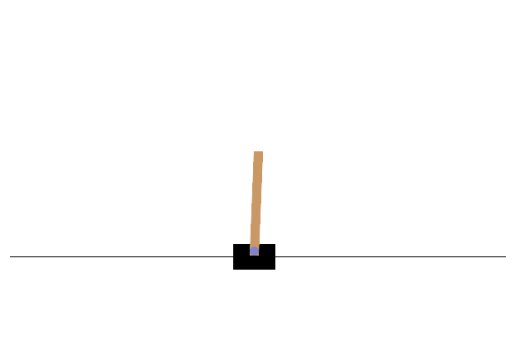

In [41]:
print("initial_state:")
# Получаем начальное изображение среды
initial_state = env.render()

# Отображаем изображение
plt.imshow(initial_state)
plt.axis('off')  # Выключить оси
plt.show()

env.close()

In [42]:
# Создание первого снимка
snap0 = env.get_snapshot()

Whoops! We died!
final state:


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


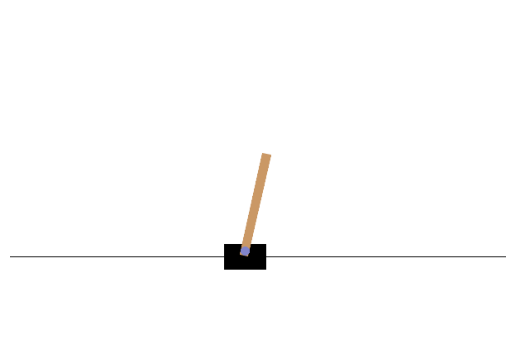

In [43]:
# Проигрывание без снимков (быстрее - случайный)
while True:
    # Выполняем случайное действие и проверяем, завершен ли эпизод
    is_done = env.step(env.action_space.sample())[2]
    if is_done:
        print("Whoops! We died!")
        break
print("final state:")
plt.imshow(env.render())
plt.axis('off')
plt.show()



After loading snapshot


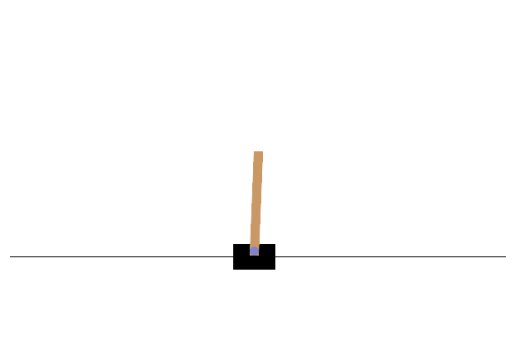

In [44]:
# Перезагрузка первичного состояния
env.load_snapshot(snap0)
print("\n\nAfter loading snapshot")
plt.imshow(env.render())
plt.axis('off')
plt.show()

In [45]:
# Получить результат выполнения случайного действия из состояния snap0(snapshot, observation, reward, is_done, info)
res = env.get_result(snap0, env.action_space.sample())

# Извлекаем данные из результата (новый снимок, наблюдение, награда)
snap1, observation, reward = res[:3]

# Второй шаг с новым состоянием (snap1)
res2 = env.get_result(snap1, env.action_space.sample())


## 3  MCTS: поиск по дереву Монте-Карло


Мы начнем с реализации класса Node — простого класса, который действует как узел MCTS и поддерживает некоторые шаги алгоритма MCTS

In [46]:
# Проверим, что объект env экземпляр класса WithSnapshots
assert isinstance(env, WithSnapshots)

In [47]:
class Node:
    """Узел дерева для MCTS
    Каждый узел соответствует результату выполнения определенного действия (self.action)
    в определенном состоянии (самородитель) и, по сути, является одной рукой в многоруком
    бандите, который мы моделируем в этом состоянии."""

    # Метаданные:
    parent = None  # Родительский узел
    qvalue_sum = 0.  # Сумма Q-значений из всех визитов (numerator) (сумма наград)
    times_visited = 0  # Счетчик визитов (denominator) (чтобы учитывать количество попыток)

    def __init__(self, parent, action):
        """
        Создает пустой узел без дочерних элементов
        Делает это, совершая действие и записывая результат
        :param parent: родительский узел
        :param action: действие для фиксации с родительского узла
        """
        self.parent = parent
        self.action = action
        self.children = set()  # Набор дочерних узлов

        # Получение результатов действий и их сохранение
        res = env.get_result(parent.snapshot, action)
        # Состояние, наблюдения, награда, завершенность эпизода
        self.snapshot, self.observation, self.immediate_reward, self.is_done, _ = res

    # Метод для опредления является ли узел листом (без дочерних листов)
    # Для определения достиг ли алгоритм конечного состояния в дереве (если нет детей, то конечная точка)
    def is_leaf(self):
        return len(self.children) == 0

    # Метод для определения является ли текущий узел корнем дерева (начальное состояние, с котрого начинается процесс поиска)
    def is_root(self):
        return self.parent is None

    # Метод для оценки Q-значения узла
    # Представляет собой среднюю награду, полученную от всех посещений этого узла
    # Если узел был посещен хотя бы один раз, то метод возвращает среднее значение
    # Если узел не был посещен, то метод возвращает 0
    def get_qvalue_estimate(self):
        return self.qvalue_sum / self.times_visited if self.times_visited != 0 else 0

    # Метод для вычисления оценки ucb1
    # Оценка UCB1 используется для балансировки между эксплуатацией (выбором действий с лучшими результатами)
    # и исследованием (выбором действий с наименьшим числом посещений для сбора доп информации)
    def ucb_score(self, scale=10, max_value=1e100):
        """
        Вычисляет верхнюю границу ucb1, используя текущее значение и количество посещений для узла и его родителя

        :param scale: Умножает на это верхнюю границу. Из неравенства Хёффдинга предполагается, что диапазон вознаграждения равен [0, шкала]
        :param max_value: значение, которое возвращается для узлов, которые еще не были посещены
        """
        # Если узел не был посещен, возвращаем максимально возможную оценку
        if self.times_visited == 0:
            return max_value

        # Вычисляем аддитивный компонент ucb-1, который регулирует степень неопределенности
        # Эта часть поощряет исследование узлов, которые были посещены меньше, так как они могут быть недооценены
        U = np.sqrt(np.log(self.parent.times_visited) / self.times_visited)
        # Возвращаем итоговую оценку UCB, которая состоит из среднего Q-значения и компонента неопределенности
        return self.get_qvalue_estimate() + scale * U

    # Метод для выбора узла с наивысшей оценкой для дальнейшего расширения
    def select_best_leaf(self):
        """
        Выбирает лист с наивысшим приоритетом для расширения
        Делает это, рекурсивно выбирая узлы с лучшим результатом UCB-1, пока не достигнет листа
        """
        if self.is_leaf():
            return self
        children = self.children # Если не лист, то выбираем дочерние узлы

        # Ищем дочерний узел с наивысшей оценкой UCB
        best_child = max(self.children, key=lambda child: child.ucb_score())
        # Возвращает оценку для каждого дочернего узла, основываясь на его количестве посещений и текущем значении
        return best_child.select_best_leaf()

    # Метод расширяет дерево, добавляя новые возможности для дальнейших шагов
    def expand(self):
        """
        Расширяет текущий узел, создавая все возможные дочерние узлы
        Затем возвращается один из этих детей
        """
        assert not self.is_done, "не может расширяться из терминального состояния"

        # Для каждого возможного действия генерируем новый дочерний узел
        # n_actions — общее количество возможных действий
        for action in range(n_actions):
            self.children.add(Node(self, action))  # Для каждого действия создаем новый дочерний узел

        # Возвращаем лучший дочерний узел
        return self.select_best_leaf()

    # Метод отвечает за симуляцию игры от текущего состояния узла до терминального состояния
    def rollout(self, t_max=10 ** 4):
        """
        Играйте в игру от этого состояния до конца (готово) или за t_max шагов
        На каждом этапе выбирайте действие случайным образом
        Вычислите сумму наград от текущего состояния до конца эпизода

        Примечание 1: используйте env.action_space.sample() для выбора случайного действия
        Примечание 2: если узел является терминальным (self.is_done имеет значение True), просто верните self.immediate_reward
        """
        # Устанавливаем среду в состояние, сохраненное в snapshot
        env.load_snapshot(self.snapshot)
        obs = self.observation # Состояние в текущий момент времени
        is_done = self.is_done # Проверка, завершен ли эпизод
        total_reward = 0  # Сумма вознаграждений

        # Выполняем шаги до завершения эпизода или достижения максимального числа шагов
        for _ in range(t_max):
            if is_done:
                break  # Если эпизод завершен, выходим из цикла

            # Выбираем случайное действие
            action = env.action_space.sample()
            # Выполняем выбранное действие в среде и получаем новое состояние и награду
            obs, reward, is_done, info, _ = env.step(action)

            total_reward += reward

        # Возвращаем сумму наград после выполнения всех шагов
        return total_reward

    # Метод для обновления статистики узла, а затем передает информацию к родительским узлам
    def propagate(self, child_qvalue):
        """
        Использует дочернее Q-значение (сумму вознаграждений) для рекурсивного обновления родителей
        """
        # Текущее Q-значение — это награда на шаге + вознаграждение от дочернего узла
        my_qvalue = self.immediate_reward + child_qvalue

        # Обновляем сумму Q-значений и количество посещений
        self.qvalue_sum += my_qvalue
        self.times_visited += 1

        # Рекурсивно обновляем родительский узел
        if not self.is_root():
            self.parent.propagate(my_qvalue)

    # Метод выполняет рекурсивное удаление узла и всех его дочерних узлов
    def safe_delete(self):
        """Безопасное удаление для предотвращения утечек памяти в некоторых версиях Python"""
        del self.parent  # Удаляем ссылку на родительский узел
        for child in self.children:
            child.safe_delete()  # Рекурсивно удаляем все дочерние узлы
        del self  # Удаляем текущий узел


class Root(Node):
    def __init__(self, snapshot, observation):
        """
        Создает специальный узел, который действует как корень дерева.

        :snapshot: Снимок (из env.get_snapshot), с которого можно начать планирование
        :observation: Последнее наблюдение за окружающей средой
        """
        self.parent = None  # Корневой узел не имеет родителя
        self.children = set()  # Выбор дочернего узла
        # root: загрузка снимка и наблюдение
        self.snapshot = snapshot  # Снимок состояния среды
        self.observation = observation  # Последнее наблюдение
        self.immediate_reward = 0  # Награда на текущем шаге
        self.is_done = False  # Эпизод еще не завершен

    @staticmethod
    def from_node(node):
        """Инициализирует узел как root"""
        root = Root(node.snapshot, node.observation)
        # Копируем данные из существующего узла
        copied_fields = ["qvalue_sum", "times_visited", "children", "is_done"]
        for field in copied_fields:
            setattr(root, field, getattr(node, field))
        return root


## 4 Основной цикл MCTS

Алгоритм:
- выбираем лучший лист
- если узел не терминальный, то создаем дочерние для всех действий и выбираем один для дальнейшего исследования
- играем начиная с текущего состояния и до конца
- после симуляции, обновляем родительские узлы с полученной наградой

In [48]:
def plan_mcts(root, n_iters=10):
    """
    Строит дерево с поиском по дереву Монте-Карло для n_iters итераций
    :param root: узел дерева для планирования
    :param n_iters: сколько циклов select-expand-simulate-propagate сделать
    """
    for _ in range(n_iters):
        # Выбор лучшего листа
        # Используем метод select_best_leaf для выбора узла с наивысшей оценкой
        node = root.select_best_leaf()

        # Если узел терминальный (игра завершена), то все развертывания с этого узла имеют 0 награды
        if node.is_done:
            node.propagate(0)
        else:
            # Развертывание  лучшего листа и создание всевозможных дочерних узлов с наивысшей оценкой
            child = node.expand()

            # Выполняем случайное действие до завершения эпизода или достижения максимального числа шагов
            reward = child.rollout()  # Получаем награду используется для обнуления узлов

            # Распространение результатов вверх
            child.propagate(reward)


## 5 Планирование и запуск

Используем реализацию MCTS, чтобы найти оптимальную политику

In [77]:
# Инициализация среды и корневого узла
env = WithSnapshots(gym.make("CartPole-v1"))  # Создаём среду с поддержкой снимков
root_observation = env.reset()  # Сбрасываем среду и получаем начальное наблюдение
root_snapshot = env.get_snapshot()  # Создаём снимок текущего состояния среды
root = Root(root_snapshot, root_observation)  # Создаём корневой узел для дерева MCTS

# Планируем дерево поиска MCTS
plan_mcts(root, n_iters=1000)  # Выполняем планирование на 1000 итераций

/usr/local/lib/python3.10/dist-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


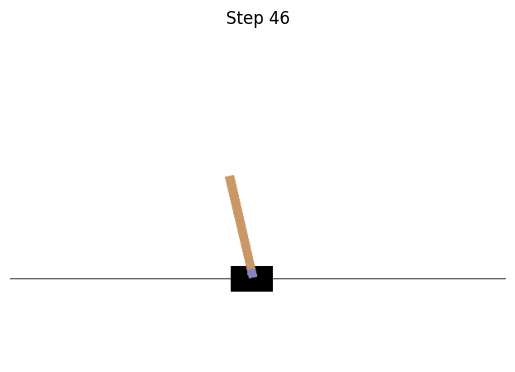

Finished with reward =  47.0


In [88]:
import gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
from itertools import count

# Инициализация тестовой среды
total_reward = 0  # Общая сумма наград
# Создаем новую среду для тестирования
test_env = WithSnapshots(gym.make("CartPole-v1", render_mode="rgb_array"))

# Сбрасываем тестовую среду
test_env.reset()

# Оборачиваем среду в RecordVideo
test_env = RecordVideo(test_env, video_folder='videos', name_prefix='test_run')

# Визуализация и взаимодействие с тестовой средой
for i in count():
    # Выбор лучшего дочернего узла на основе среднего значения наград
    best_child = max(root.children, key=lambda child: child.get_qvalue_estimate())

    # Выполнение действия, связанного с лучшим узлом
    s, r, done, info, _ = test_env.step(best_child.action)
    print(f"Step {i}, State: {s}, Reward: {r}, Done: {done}")

    # Отображаем текущее состояние среды
    clear_output(True)
    plt.title(f"Step {i}")

    # Используем render для отображения изображения
    img = test_env.unwrapped.render()
    if img is not None:
        plt.imshow(img)  # Рендерим изображение среды
        plt.axis('off')
        plt.show()
    else:
        print("Error: render returned None")

    # Обновляем всю награду
    total_reward += r

    # Если эпизод завершён, выводим результат и завершаем цикл
    if done:
        print("Finished with reward = ", total_reward)
        # Закрываем тестовую среду
        test_env.close()
        break

    # Удаляем из дерева все дочерние узлы, кроме лучшего
    for child in root.children:
        if child != best_child:
            child.safe_delete()

    # Объявляем лучшего потомка новым корнем дерева
    root = Root.from_node(best_child)

    # Проверяем, не закончились ли листья дерева
    assert not root.is_leaf(), \
        "У нас закончилось дерево! Нужно больше планирования! Попробуйте вырастить дерево прямо внутри цикла."

    # Дополнительное планирование для роста дерева
    plan_mcts(root, n_iters=100)  # Выполняем дополнительные итерации планирования
